Implementar una red neuronal (sin POO) de dos capas totalmente conectadas para resolver\
el problema de CIFAR-10. Las 100 neuronas de la primer capa tienen como función de ac-\
tivación a la función sigmoidal. La segunda capa es la de salida y esta formada por 10\
neuronas con una activación lineal. Como función de costo utilizar MSE y agregue un ter-\
mino de regularización L2.

In [ ]:
#Este programa está bien feo, pero funciona. Mi "error" es que calculé
#los gradientes sin hacer backprop, sino de la manera tradicional.
#El ej. 4 es igual pero con otra función de loss, así que voy a implementarlo
#con backprop

In [1]:
import numpy as np
from scipy import linalg
from scipy.special import expit
from matplotlib import pyplot as plt
from keras.datasets import cifar10

In [2]:
(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()

ytrain = ytrain[:,0]
ytest = ytest[:,0]

# summarize loaded dataset
print('Train: X=%s, y=%s' % (Xtrain.shape, ytrain.shape))
print('Test: X=%s, y=%s' % (Xtest.shape, ytest.shape))

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


In [3]:
names_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 
              3: 'cat', 4: 'deer', 5: 'dog', 
              6: 'frog', 7: 'horse', 8: 'ship', 
              9: 'truck'}

In [4]:
def clean(X):
        X_norm = X.reshape(len(X), X[0].size).astype(float)
        X_norm -= np.mean(X)
        X_norm /= np.std(X).astype(float)
        return X_norm

In [5]:
def sigmoid(z):
    return expit(z)

def sigprime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [6]:
Xtrain_n = clean(Xtrain)
Xtest_n = clean(Xtest)

print(Xtrain_n.shape)

(50000, 3072)


In [7]:
#Acá van todas las variables del sistema. Las voy a dejar como variables globales por esta vez
def Init():
    global s, y, a, z, W1, b1, W2, b2, grads1, grads2, gradb1, gradb2, grads
    s = Xtrain_n[0].size
    y = np.zeros([10,1], dtype=float)
    a = np.zeros([100, 1], dtype=float)
    z = np.zeros_like(a)
    W1 = np.random.uniform(-.01, .01, size=(s, 100))
    b1 = np.random.uniform(-.01, .01)
    W2 = np.random.uniform(-.01, .01, size=(100, 10))
    b2 = np.random.uniform(-.01, .01)
    #Hago un array de arrays para los gradientes
    grads1 = np.zeros_like(W1)
    grads2 = np.zeros_like(W2)
    gradb1 = np.array([0], dtype=float)
    gradb2 = np.array([0], dtype=float)
    grads = np.array([grads1, grads2, gradb1, gradb2], dtype=object)
    
Init()

In [8]:
def forward(x):
    global a, y, z    
    z = np.dot(W1.T, x) + b1
    a = sigmoid(z)
    y = np.dot(W2.T, a) + b2

In [9]:
def loss_function(yex, ytrue):
    diff = np.copy(yex)
    # ya que ytrue funciona como índice, le resto 1 a yex[ytrue]
    diff[ytrue] -= 1
    return linalg.norm(diff)**2, diff


In [10]:
def gradient(x, diff):
    #diff es el vector (y - ytrue)
    global grads, z, a
    #aux = np.zeros_like(W2)
    sprim = sigprime(z)
    #for i in range(10):
    #    aux[:,i] = W2[:,i] * sprim
        
    grads[0] = np.outer(x, np.dot(W2, diff)*sprim)
    grads[1] = np.outer(a, diff.T)
    grads[2] = np.dot(np.dot(sprim.T, W2), diff)
    grads[3] = np.sum(diff)

    return grads

In [11]:
def update_weights(grads, alpha=.01):
    global W1, W2, b1, b2
    W1 -= alpha * grads[0]
    W2 -= alpha * grads[1]
    b1 -= alpha * grads[2]
    b2 -= alpha * grads[3]
    

In [12]:
def predict(x):
    return forward(x)

def accuracy(y, ytrue):
    return float(np.sum(y==ytrue))/float(len(ytrue))

In [51]:
m = Xtrain_n.shape[0]
batch_size = 2000
n_batches = int(m/batch_size)
epochs = 100
lambda_ = 0.01
alpha =.05

loss = np.array(0, dtype=float)
gradaux = np.zeros_like(grads)
loss_hist = []

#Init()
for epoch in range(epochs):
    for batch in range(n_batches):
        loss = 0
        gradaux = 0
        example = Xtrain_n[batch*batch_size:(1+batch)*batch_size,:]
        yexample = ytrain[batch*batch_size:(1+batch)*batch_size]

        for i in range(batch_size):
            forward(example[i,:])
            (aux, diff) = loss_function(y, yexample[i])
            loss += aux
            gradaux += gradient(example[i,:], diff)
        #regularización
        L2 = linalg.norm(W1)**2 + linalg.norm(W2)**2

        loss += lambda_ * L2/(2*alpha)
        loss /= (2*batch_size)

        gradaux[0] += lambda_ * W1/alpha
        gradaux[1] += lambda_ * W2/alpha
        gradaux /= batch_size
        
        update_weights(gradaux, alpha)
        loss_hist.append(loss)

    print(epoch, loss)



0 0.3632994513876484
1 0.3629355451999875
2 0.3625784296165847
3 0.3622256382111378
4 0.36187671770572316
5 0.36153148048553735
6 0.36118981442186554
7 0.36085163921710295
8 0.3605168890977037
9 0.3601855042281617
10 0.359857426249079
11 0.35953259602885307
12 0.35921095264595665
13 0.35889243306022683
14 0.35857697216754586
15 0.3582645030625258
16 0.3579549574066691
17 0.3576482658409772
18 0.35734435840620843
19 0.3570431649486423
20 0.3567446154982671
21 0.3564486406120678
22 0.3561551716787575
23 0.3558641411836645
24 0.35557548293396485
25 0.3552891322455157
26 0.3550050260932159
27 0.354723103227402
28 0.3544433042592598
29 0.3541655717186173
30 0.3538898500878148
31 0.35361608581551046
32 0.35334422731436177
33 0.35307422494639956
34 0.35280603099959723
35 0.3525395996587423
36 0.3522748869731344
37 0.35201185082294045
38 0.3517504508854496
39 0.35149064860170715
40 0.3512324071434521
41 0.3509756913797779
42 0.3507204678425283
43 0.35046670468925456
44 0.35021437166243635
45 0

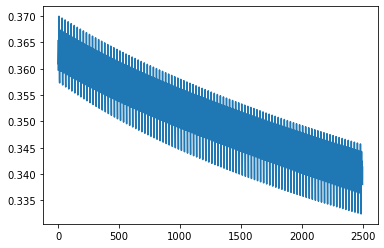

In [52]:
plt.plot(loss_hist)

In [53]:
#testeamos un poco
ytrguess = []
yguess = []
size = 50000
for i in range(size):
    predict(Xtrain_n[i,:])
    ytrguess.append(np.argmax(y))
    if i < 10000:
        predict(Xtest_n[i,:])
        yguess.append(np.argmax(y))
    
print("Train accuracy: ",100*accuracy(ytrguess, ytrain[0:size]))
print("Test accuracy: ",100*accuracy(yguess, ytest[0:size]))

Train accuracy:  50.066
Test accuracy:  47.15
